In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [ ]:
import xgboost
print(xgboost.__version__)

2.1.4


In [ ]:
# 1. Đọc và làm sạch dữ liệu
df = pd.read_csv('/content/drive/MyDrive/BD_DA/AirQuality.csv', sep=';', decimal=',')

In [ ]:
print("Trước khi xử lý:", df.shape)

Trước khi xử lý: (9471, 17)


In [ ]:
# Thay thế -200 bằng NaN
df.replace(-200, np.nan, inplace=True)
print("Sau khi thay thế -200:", df.shape)

# Chuyển đổi các cột số về kiểu float (tránh lỗi khi nội suy)
numeric_cols = df.select_dtypes(include=['object']).columns
for col in numeric_cols:
    if col not in ['Date', 'Time']:  # Giữ nguyên Date và Time
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Nội suy tuyến tính để điền giá trị thiếu
df.interpolate(method='linear', inplace=True)
print("Sau khi nội suy:", df.shape)

# Kiểm tra và loại bỏ các cột không cần thiết
df.drop(columns=['Unnamed: 15', 'Unnamed: 16'], errors='ignore', inplace=True)
print("Sau khi loại bỏ cột 2 cột unnamed 15 và 16:", df.shape)

# Giữ nguyên kiểu dữ liệu của Date và Time trước khi tạo Timestamp
df['Date'] = df['Date'].astype(str)
df['Time'] = df['Time'].astype(str)

# Kết hợp Date và Time thành Timestamp
df['Timestamp'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S', errors='coerce')
df.drop(['Date', 'Time'], axis=1, inplace=True)

print("Sau khi tạo Timestamp:", df.shape)

Sau khi thay thế -200: (9471, 17)
Sau khi nội suy: (9471, 17)
Sau khi loại bỏ cột 2 cột unnamed 15 và 16: (9471, 15)
Sau khi tạo Timestamp: (9471, 14)


<ipython-input-5-56a926060a7a>:12: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(method='linear', inplace=True)


In [ ]:
# 2. Tạo đặc trưng mới
df['Hour'] = df['Timestamp'].dt.hour
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
df['Month'] = df['Timestamp'].dt.month
df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
df['NOx_NO2_Ratio'] = df['NOx(GT)'] / (df['NO2(GT)'] + 1e-5)
df['Temp_Humidity'] = df['T'] * df['RH']
df['CO_Lag1'] = df['CO(GT)'].shift(1)
df.dropna(inplace=True)

In [ ]:
# Không dùng dropna() ngay, chỉ kiểm tra số lượng NaN
print("Số NaN trước khi drop:", df.isna().sum())

Số NaN trước khi drop: CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
Timestamp        0
Hour             0
DayOfWeek        0
Month            0
IsWeekend        0
NOx_NO2_Ratio    0
Temp_Humidity    0
CO_Lag1          0
dtype: int64


In [ ]:
# 3. Chọn đặc trưng và mục tiêu
features = ['PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)',
            'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH',
            'Hour', 'DayOfWeek', 'Month', 'IsWeekend', 'NOx_NO2_Ratio', 'Temp_Humidity', 'CO_Lag1']
target = 'CO(GT)'

X = df[features]
y = df[target]

In [ ]:
print(df.head())  # Xem thử 5 dòng đầu
print(df.info())  # Kiểm tra kiểu dữ liệu


   CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
1     2.0       1292.0     112.0       9.4          955.0    103.0   
2     2.2       1402.0      88.0       9.0          939.0    131.0   
3     2.2       1376.0      80.0       9.2          948.0    172.0   
4     1.6       1272.0      51.0       6.5          836.0    131.0   
5     1.2       1197.0      38.0       4.7          750.0     89.0   

   PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  ...    RH      AH  \
1        1174.0     92.0        1559.0        972.0  ...  47.7  0.7255   
2        1140.0    114.0        1555.0       1074.0  ...  54.0  0.7502   
3        1092.0    122.0        1584.0       1203.0  ...  60.0  0.7867   
4        1205.0    116.0        1490.0       1110.0  ...  59.6  0.7888   
5        1337.0     96.0        1393.0        949.0  ...  59.2  0.7848   

            Timestamp  Hour  DayOfWeek  Month  IsWeekend  NOx_NO2_Ratio  \
1 2004-03-10 19:00:00  19.0        2.0    3.0          0   

In [ ]:
print("Kích thước X:", X.shape)
print("Kích thước y:", y.shape)


Kích thước X: (9356, 19)
Kích thước y: (9356,)


In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Kích thước tập train:", X_train.shape, y_train.shape)
print("Kích thước tập validation:", X_val.shape, y_val.shape)
print("Kích thước tập test:", X_test.shape, y_test.shape)


Kích thước tập train: (7484, 19) (7484,)
Kích thước tập validation: (936, 19) (936,)
Kích thước tập test: (936, 19) (936,)


In [ ]:
# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# Định nghĩa các mô hình cơ sở
base_models = [
    RandomForestRegressor(n_estimators=100, random_state=42),
    GradientBoostingRegressor(n_estimators=100, random_state=42),
    MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
]

# K-Fold để tạo dữ liệu meta
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Tạo tập dữ liệu meta
base_predictions_train = np.zeros((X_train_scaled.shape[0], len(base_models)))
base_predictions_val = np.zeros((X_val_scaled.shape[0], len(base_models)))
base_predictions_test = np.zeros((X_test_scaled.shape[0], len(base_models)))

# Huấn luyện mô hình cơ sở với K-Fold
for i, model in enumerate(base_models):
    val_preds = np.zeros(X_train_scaled.shape[0])  # Dự đoán trung gian
    for train_idx, val_idx in kf.split(X_train_scaled):
        model.fit(X_train_scaled[train_idx], y_train.iloc[train_idx])
        val_preds[val_idx] = model.predict(X_train_scaled[val_idx])  # Dự đoán trên tập validation

    base_predictions_train[:, i] = val_preds  # Lưu dự đoán K-Fold vào tập train

    # Huấn luyện lại mô hình trên toàn bộ tập train và dự đoán trên tập val & test
    model.fit(X_train_scaled, y_train)
    base_predictions_val[:, i] = model.predict(X_val_scaled)
    base_predictions_test[:, i] = model.predict(X_test_scaled)

# Đánh giá MSE của từng mô hình cơ sở
for i, model in enumerate(base_models):
    mse = mean_squared_error(y_val, base_predictions_val[:, i])
    print(f"MSE của {model.__class__.__name__}: {mse}")

# Xây dựng mô hình meta (XGBoost)
meta_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
meta_model.fit(base_predictions_train, y_train)

# Dự đoán trên tập validation và test
y_pred_val = meta_model.predict(base_predictions_val)
y_pred_test = meta_model.predict(base_predictions_test)

# Đánh giá mô hình
mse_val = mean_squared_error(y_val, y_pred_val)
mse_test = mean_squared_error(y_test, y_pred_test)
print(f'MSE trên tập validation: {mse_val}')
print(f'MSE trên tập kiểm tra: {mse_test}')

MSE của RandomForestRegressor: 0.12790431937115043
MSE của GradientBoostingRegressor: 0.1707643830084941
MSE của MLPRegressor: 0.09762584924160514
MSE trên tập validation: 0.1118342463657277
MSE trên tập kiểm tra: 0.0994969367278873


In [ ]:
# 6. Gán nhãn cho dự đoán
def get_label(co_value):
    if co_value < 4.5:
        return "Tốt"
    elif co_value < 9.0:
        return "Trung bình"
    elif co_value < 15.0:
        return "Kém"
    else:
        return "Nguy hiểm"

labels_test = [get_label(pred) for pred in y_pred_test]
print("\nDự đoán và nhãn trên tập kiểm tra (5 mẫu đầu tiên):")
for i in range(min(5, len(y_pred_test))):
    print(f"Dự đoán CO(GT): {y_pred_test[i]:.2f} mg/m³ - {labels_test[i]}")


Dự đoán và nhãn trên tập kiểm tra (5 mẫu đầu tiên):
Dự đoán CO(GT): 2.26 mg/m³ - Tốt
Dự đoán CO(GT): 2.30 mg/m³ - Tốt
Dự đoán CO(GT): 3.03 mg/m³ - Tốt
Dự đoán CO(GT): 0.33 mg/m³ - Tốt
Dự đoán CO(GT): 1.51 mg/m³ - Tốt


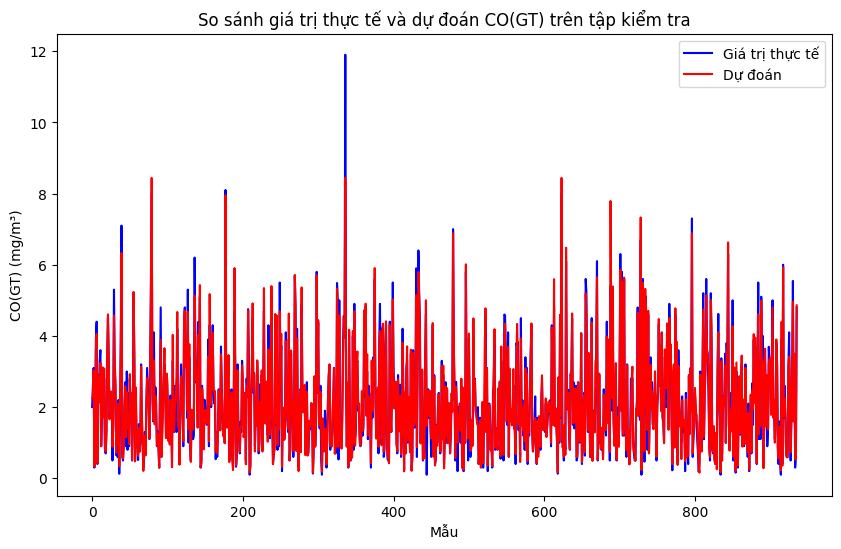

In [ ]:
# 7. Trực quan hóa dữ liệu
# Biểu đồ so sánh giá trị thực tế và dự đoán trên tập kiểm tra
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Giá trị thực tế', color='blue')
plt.plot(y_pred_test, label='Dự đoán', color='red')
plt.title('So sánh giá trị thực tế và dự đoán CO(GT) trên tập kiểm tra')
plt.xlabel('Mẫu')
plt.ylabel('CO(GT) (mg/m³)')
plt.legend()
plt.show()

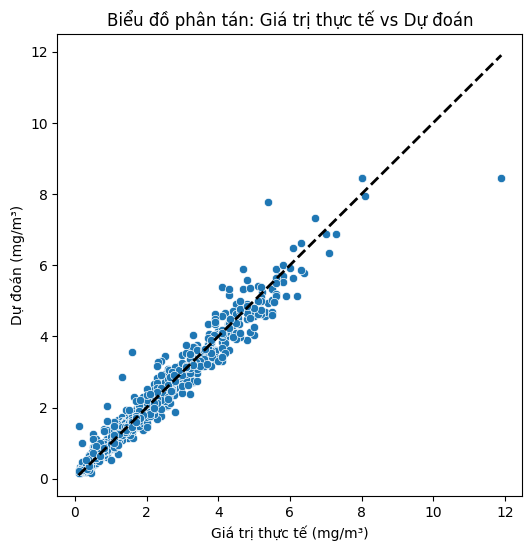

In [ ]:
# Biểu đồ phân tán
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred_test)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Biểu đồ phân tán: Giá trị thực tế vs Dự đoán')
plt.xlabel('Giá trị thực tế (mg/m³)')
plt.ylabel('Dự đoán (mg/m³)')
plt.show()

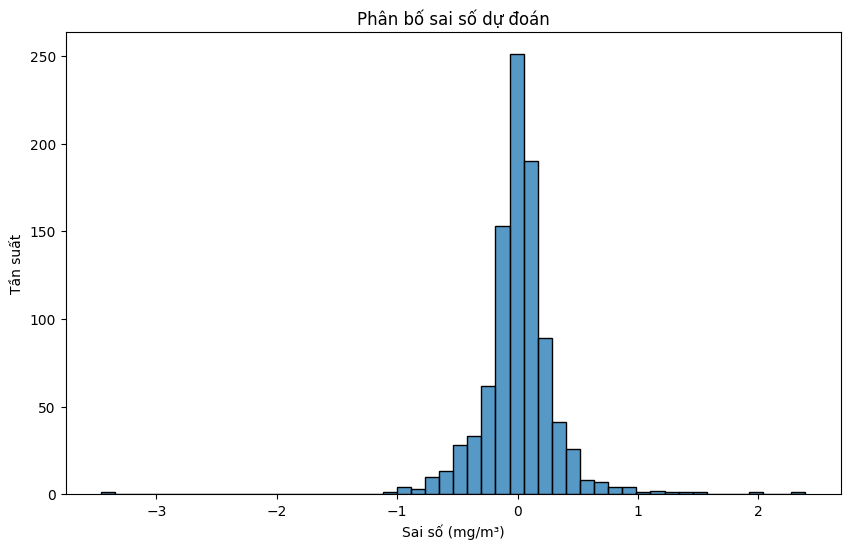

In [ ]:
errors = y_pred_test - y_test
plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=50)
plt.title('Phân bố sai số dự đoán')
plt.xlabel('Sai số (mg/m³)')
plt.ylabel('Tần suất')
plt.show()

In [ ]:
# 7. Hàm dự đoán với dữ liệu mới
def predict_new_data(new_data, scaler, base_models, meta_model):
    # Chuyển đổi new_data thành DataFrame với cùng cột
    new_df = pd.DataFrame([new_data], columns=features)

    # Tính toán các đặc trưng bổ sung
    new_df['Hour'] = pd.to_datetime('15/03/2025 10:00:00').hour  # Ví dụ giờ
    new_df['DayOfWeek'] = pd.to_datetime('15/03/2025 10:00:00').dayofweek
    new_df['Month'] = pd.to_datetime('15/03/2025 10:00:00').month
    new_df['IsWeekend'] = 0 if new_df['DayOfWeek'][0] < 5 else 1
    new_df['NOx_NO2_Ratio'] = new_df['NOx(GT)'] / (new_df['NO2(GT)'] + 1e-5)
    new_df['Temp_Humidity'] = new_df['T'] * new_df['RH']
    new_df['CO_Lag1'] = df['CO(GT)'].iloc[-1]  # Lấy giá trị CO(GT) cuối cùng từ tập dữ liệu cũ

    # Chuẩn hóa dữ liệu mới
    new_data_scaled = scaler.transform(new_df[features])

    # Dự đoán từ các mô hình cơ sở
    base_predictions = [model.predict(new_data_scaled) for model in base_models]
    X_meta_new = np.column_stack(base_predictions)

    # Dự đoán từ mô hình meta
    y_pred_new = meta_model.predict(X_meta_new)[0]

    # Gán nhãn
    label_new = get_label(y_pred_new)

    return y_pred_new, label_new

# 8. Test với dữ liệu mới
new_data = {
    'PT08.S1(CO)': 1000, 'NMHC(GT)': 50, 'C6H6(GT)': 10, 'PT08.S2(NMHC)': 900,
    'NOx(GT)': 150, 'PT08.S3(NOx)': 800, 'NO2(GT)': 100, 'PT08.S4(NO2)': 700,
    'PT08.S5(O3)': 600, 'T': 15, 'RH': 60, 'AH': 10
}

# Dự đoán
predicted_value, predicted_label = predict_new_data(new_data, scaler, base_models, meta_model)
print(f"\nDự đoán cho dữ liệu mới: CO(GT) = {predicted_value:.2f} mg/m³ - {predicted_label}")


Dự đoán cho dữ liệu mới: CO(GT) = 1.33 mg/m³ - Tốt


<ipython-input-28-265dd01ee3cb>:7: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  new_df['Hour'] = pd.to_datetime('15/03/2025 10:00:00').hour  # Ví dụ giờ
<ipython-input-28-265dd01ee3cb>:8: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  new_df['DayOfWeek'] = pd.to_datetime('15/03/2025 10:00:00').dayofweek
<ipython-input-28-265dd01ee3cb>:9: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  new_df['Month'] = pd.to_datetime('15/03/2025 10:00:00').month


In [ ]:
import joblib
from google.colab import files

In [ ]:
# 6. Lưu mô hình và scaler
for i, model in enumerate(base_models):
    joblib.dump(model, f'base_model_{i}.pkl')
joblib.dump(meta_model, 'meta_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

# Tải file về máy
files.download('base_model_0.pkl')
files.download('base_model_1.pkl')
files.download('base_model_2.pkl')
files.download('meta_model.pkl')
files.download('scaler.pkl')

In [ ]:
df.to_csv('/content/drive/MyDrive/final.csv', index=False)